In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from xgboost import XGBClassifier, plot_importance

/Users/supakrit-a/Code/netviser/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data(project_path: str) -> pd.DataFrame:
    """
    Load network intrusion detection datasets from multiple days and concatenate them into a single DataFrame.
    
    Parameters:
    - project_path (str): The root directory of the project.
    
    Returns:
    - pd.DataFrame: Concatenated DataFrame containing data from all specified days.
    """
    print('1. Loading Data...')
    days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
    dfs = []

    for day in days:
        file_path = os.path.join(project_path, 'data', 'cicids2017', f'{day}.csv')
        print(f"   Loading data for {day}: {file_path}")
        try:
            df = pd.read_csv(file_path)
            dfs.append(df)
            print(f"   Successfully loaded {len(df)} records for {day}.")
        except FileNotFoundError:
            print(f"   File not found: {file_path}. Skipping {day}.")
        except Exception as e:
            print(f"   Error loading {file_path}: {e}. Skipping {day}.")

    if not dfs:
        raise ValueError("No data files were loaded. Please check the file paths and existence.")

    full_df = pd.concat(dfs, ignore_index=True)
    print(f"   Total records loaded: {len(full_df)}")
    print(f"   Columns in dataset: {list(full_df.columns)}\n")

    return full_df

def preprocess_data(project_path: str, full_df: pd.DataFrame) -> tuple:
    """
    Preprocess the dataset by cleaning, transforming, and preparing features.
    
    Parameters:
    - full_df (pd.DataFrame): The raw DataFrame loaded from CSV files.
    
    Returns:
    - tuple: Preprocessed DataFrame, LabelEncoder, label distribution.
    """
    print("2. Data Preprocessing...")

    # Clean Column Names
    full_df.columns = full_df.columns.str.strip()

    # Convert Timestamp
    full_df['Timestamp'] = pd.to_datetime(full_df['Timestamp'], errors='coerce')
    full_df = full_df.sort_values(by='Timestamp').reset_index(drop=True)

    # Filter Label
    print("   Filtering labels...")
    categories = [
        "BENIGN", "DDoS", "DoS Slowloris", "DoS Slowhttptest", "DoS Hulk", 
        "DoS GoldenEye", "Heartbleed", "Portscan", "Botnet", "FTP-Patator", 
        "SSH-Patator", "Web Attack - Brute Force", "Web Attack - XSS",
        "Web Attack - SQL Injection", "Infiltration"
    ]
    full_df = full_df[full_df['Label'].isin(categories)]

    # Feature Selection: Drop irrelevant columns
    irrelevant_columns = ["id", "Flow ID", "Attempted Category", "Timestamp",
                          "Src IP", "Dst IP", 'Hour', 'Day']
    full_df.drop(columns=irrelevant_columns, axis=1, inplace=True, errors='ignore')
    print(f"   Dropped columns: {irrelevant_columns}")

    # Handle Missing Values
    print("   Handling missing values...")
    full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    initial_len = len(full_df)
    full_df.dropna(axis=0, how='any', inplace=True)
    print(f"   Dropped {initial_len - len(full_df)} records due to missing values.")

    # Encode Labels
    print("   Encoding labels...")
    label_col = 'Label'
    label_encoder = LabelEncoder()
    full_df['Label_Enc'] = label_encoder.fit_transform(full_df[label_col])

    # Save Label Encoder as pickle
    label_encoder_path = os.path.join(project_path, 'models', 'label_encoder.pkl')
    joblib.dump(label_encoder, label_encoder_path)
    

    print("   Unique labels:", label_encoder.classes_)
    print("   Label distribution:")
    label_dist = full_df['Label'].value_counts()
    print(label_dist)
    print(f"   Records after preprocessing: {len(full_df)}\n")

    return full_df, label_encoder, label_dist

def prepare_data(full_df: pd.DataFrame) -> tuple:
    """
    Prepare data for machine learning by splitting and scaling.
    
    Parameters:
    - full_df (pd.DataFrame): The preprocessed DataFrame.
    
    Returns:
    - tuple: Scaled training features, scaled testing features, training labels, testing labels, feature column names, label column name, scaler object.
    """
    print("3. Data Preparation...")

    # Define Features and Target
    label_col = 'Label_Enc'
    feature_cols = [
        'Src Port', 'Dst Port', 'Total TCP Flow Time', 'Bwd Init Win Bytes', 'Bwd Packet Length Std', 
        'Total Length of Fwd Packet', 'Fwd Packet Length Max', 'Bwd IAT Mean', 'Flow IAT Min', 'Fwd PSH Flags'
    ]

    X = full_df[feature_cols]
    y = full_df[label_col]

    # Train-Test Split with Stratification
    print("   Performing train-test split...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42
    )
    print(f"   Training set size: {X_train.shape[0]} records")
    print(f"   Testing set size: {X_test.shape[0]} records")

    # Feature Scaling
    print("   Scaling features...")
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("   Feature scaling completed.\n")

    return X_train_scaled, X_test_scaled, y_train, y_test, feature_cols, label_col, scaler

def compute_sample_weights(y_train: pd.Series) -> np.ndarray:
    """
    Compute sample weights based on class distribution to handle class imbalance.
    
    Parameters:
    - y_train (pd.Series): Training labels.
    
    Returns:
    - np.ndarray: Array of sample weights.
    """
    print("4. Computing Sample Weights...")

    # Compute class weights
    classes = np.unique(y_train)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_train
    )
    class_weight_dict = dict(zip(classes, class_weights))
    print("   Class weights:", class_weight_dict)

    # Assign weights to each sample
    sample_weights = y_train.map(class_weight_dict).values
    print("   Sample weights computed.\n")

    return sample_weights

def train_model(X_train, y_train, X_val, y_val, num_classes, sample_weights, scaler, project_path: str) -> XGBClassifier:
    """
    Train XGBoost Classifier with sample weights and save the model and scaler.
    
    Parameters:
    - X_train (np.ndarray): Scaled training features.
    - y_train (pd.Series): Training labels.
    - X_val (np.ndarray): Scaled validation features.
    - y_val (pd.Series): Validation labels.
    - num_classes (int): Number of unique classes.
    - sample_weights (np.ndarray): Sample weights for training data.
    - scaler (MinMaxScaler): Scaler object used for feature scaling.
    - project_path (str): Path to the project directory.
    
    Returns:
    - XGBClassifier: Trained XGBoost classifier.
    """
    print("\n5. Model Training...")

    # Initialize XGBoost Classifier with desired parameters
    xgb_clf = XGBClassifier(
        objective='multi:softprob',          # Use softprob for multi-class probabilities
        num_class=num_classes,               # Number of classes
        eval_metric='mlogloss',              # Evaluation metric
        random_state=42,
        n_estimators=500,                   # Number of boosting rounds
        reg_alpha=0.0001,                    # L1 regularization term
        reg_lambda=1,                        # L2 regularization term
        verbosity=1,
        n_jobs=-1
    )

    # Train the Model with early stopping
    print("   Training XGBoost Classifier with early stopping...")
    xgb_clf.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        sample_weight=sample_weights,
        verbose=100,
    )
    print("   Training completed.")

    # Create the models directory if it doesn't exist
    models_dir = os.path.join(project_path, 'models')
    os.makedirs(models_dir, exist_ok=True)

    # Save the model
    model_path = os.path.join(models_dir, 'xgb_classifier.pkl')
    joblib.dump(xgb_clf, model_path)
    print(f"   Model saved to '{model_path}'")

    # Save the scaler
    scaler_path = os.path.join(models_dir, 'scaler.pkl')
    joblib.dump(scaler, scaler_path)
    print(f"   Scaler saved to '{scaler_path}'\n")

    return xgb_clf

def evaluate_model(model: XGBClassifier, X_test: np.ndarray, y_test: pd.Series, label_encoder: LabelEncoder):
    """
    Evaluate model performance on the test set.
    
    Parameters:
    - model (XGBClassifier): Trained XGBoost classifier.
    - X_test (np.ndarray): Scaled testing features.
    - y_test (pd.Series): Testing labels.
    - label_encoder (LabelEncoder): Fitted LabelEncoder object.
    """
    print("\n6. Model Evaluation...")

    # Predictions
    print("   Making predictions...")
    y_pred = model.predict(X_test)

    # Classification Report
    print("\n   Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for XGBoost Classifier')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Performance Metrics
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)

    print(f"   Macro F1 Score: {macro_f1:.4f}")
    print(f"   Accuracy: {accuracy:.4f}\n")

def visualize_feature_importance(model: XGBClassifier, feature_names: list, max_features: int = 20):
    """
    Visualize feature importance using XGBoost's built-in plot_importance.
    
    Parameters:
    - model (XGBClassifier): Trained XGBoost classifier.
    - feature_names (list): List of feature names.
    - max_features (int): Number of top features to display.
    """
    print("7. Feature Importance Visualization...")
    plt.figure(figsize=(12, 8))
    plot_importance(model, max_num_features=max_features, importance_type='gain', show_values=False)
    plt.title('Feature Importance - XGBoost Classifier')
    plt.show()

1. Loading Data...
   Loading data for monday: /Users/supakrit-a/Code/netviser/data/cicids2017/monday.csv
   Successfully loaded 371624 records for monday.
   Loading data for tuesday: /Users/supakrit-a/Code/netviser/data/cicids2017/tuesday.csv
   Successfully loaded 322078 records for tuesday.
   Loading data for wednesday: /Users/supakrit-a/Code/netviser/data/cicids2017/wednesday.csv
   Successfully loaded 496641 records for wednesday.
   Loading data for thursday: /Users/supakrit-a/Code/netviser/data/cicids2017/thursday.csv
   Successfully loaded 362076 records for thursday.
   Loading data for friday: /Users/supakrit-a/Code/netviser/data/cicids2017/friday.csv
   Successfully loaded 547557 records for friday.
   Total records loaded: 2099976
   Columns in dataset: ['id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Lengt

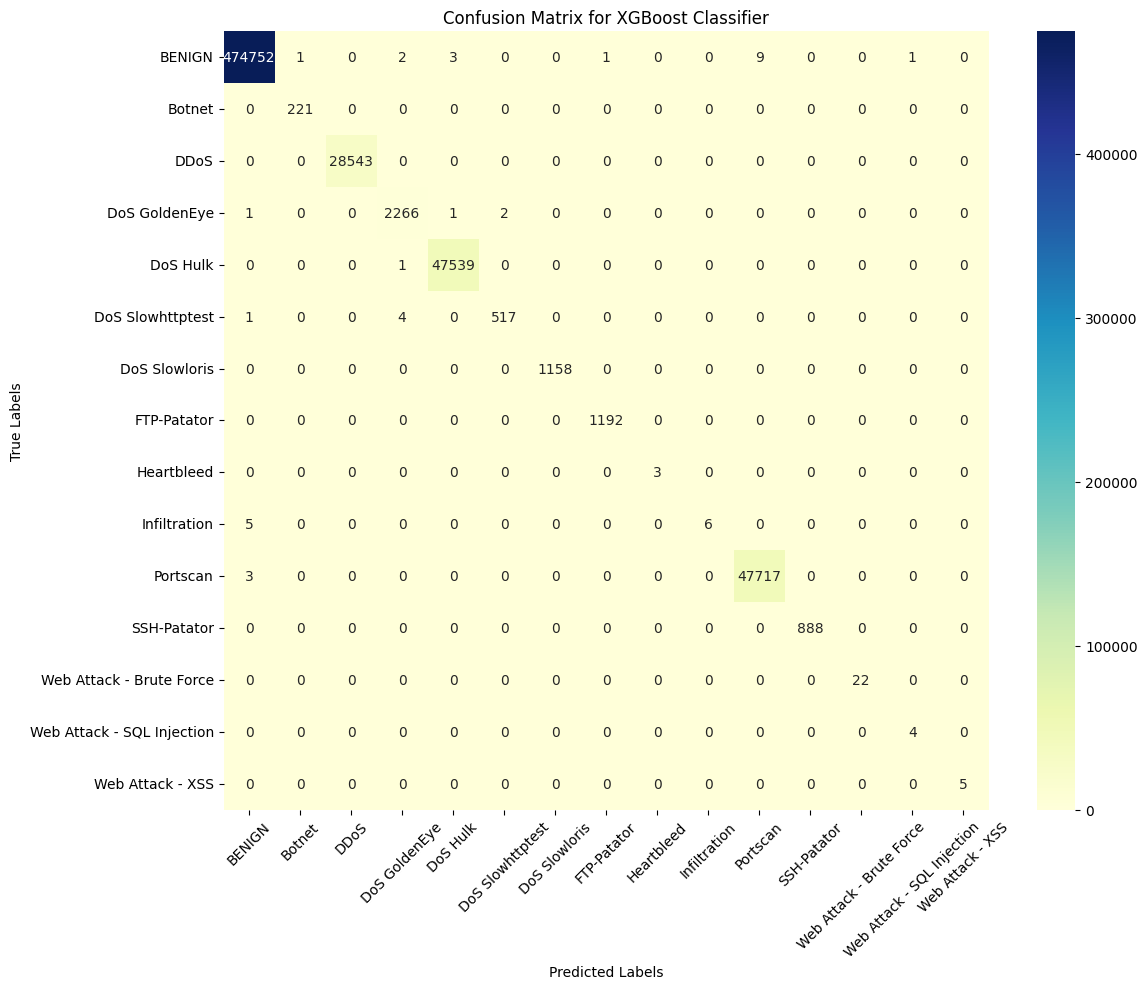

   Macro F1 Score: 0.9722
   Accuracy: 0.9999

7. Feature Importance Visualization...


<Figure size 1200x800 with 0 Axes>

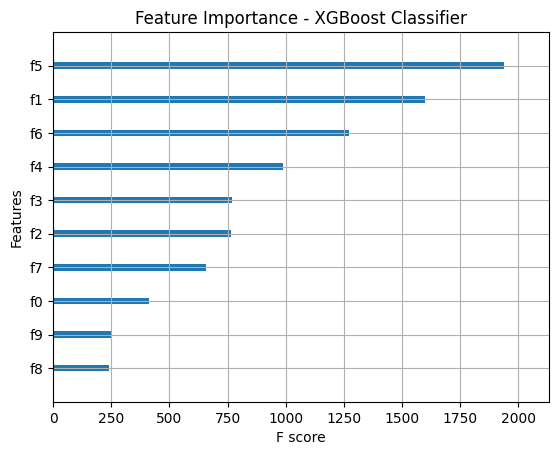

In [3]:

project_path = '/Users/supakrit-a/Code/netviser'

# Step 1: Load Data
df = load_data(project_path)

# Step 2: Preprocess Data
df, label_encoder, label_dist = preprocess_data(project_path=project_path, full_df=df)

# Step 3: Prepare Data
X_train_scaled, X_test_scaled, y_train, y_test, feature_cols, label_col, scaler = prepare_data(df)

# Further split training data into training and validation sets
print("   Splitting training data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=42
)
print(f"   Training set size: {X_train.shape[0]} records")
print(f"   Validation set size: {X_val.shape[0]} records\n")

# Step 4: Compute Sample Weights
sample_weights = compute_sample_weights(y_train)

# Step 5: Train Model
num_classes = len(label_encoder.classes_)
model = train_model(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    num_classes=num_classes,
    sample_weights=sample_weights,
    scaler=scaler,
    project_path=project_path
)

# Step 6: Evaluate Model
evaluate_model(
    model=model,
    X_test=X_test_scaled,
    y_test=y_test,
    label_encoder=label_encoder
)

# Step 7: Visualize Feature Importance
visualize_feature_importance(
    model=model,
    feature_names=feature_cols,
    max_features=20
)
